In [2]:
# Importing the necessary libraries.
import pandas as pd
import numpy as np
import gzip
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
ti_network_file = '/home/noor/Insync/npsingh@umd.edu/Google Drive/fall_2019/828-O/assignment/assign3/chilean_TI.txt'

In [19]:
df = pd.read_csv(ti_network_file,sep = '\t')

In [20]:
metadata_nodes = df[df.columns[:2].values]
print(df)
print(metadata_nodes)

     Unnamed: 0                 Unnamed: 1  1  2  3  4  5  6  7  8  ...  101  \
0             1          acanthina monodon  0  0  0  0  0  0  0  0  ...    0   
1             2         acanthocyclus gayi  0  1  1  0  0  0  0  0  ...    0   
2             3     acanthocyclus hassleri  0  1  1  0  0  0  0  0  ...    0   
3             4     acanthopleura echinata  0  0  0  0  0  0  0  0  ...    0   
4             5     chaetopleura peruviana  0  0  0  0  0  0  0  0  ...    0   
..          ...                        ... .. .. .. .. .. .. .. ..  ...  ...   
101         106    petrolisthes spinifrons  0  0  0  0  0  0  0  0  ...    1   
102         107     petrolisthes angulosus  0  0  0  0  0  0  0  0  ...    1   
103         108  petrolisthes tuberculatus  0  0  0  0  0  0  0  0  ...    1   
104         109  petrolisthes tuberculosus  0  0  0  0  0  0  0  0  ...    1   
105         110     trimusculus peruvianus  0  0  0  0  0  0  0  0  ...    0   

     102  103  104  105  106  107  108 

In [22]:
metadata_nodes = df[df.columns[:2].values]
metadata_nodes.columns = ['node_id', 'sp_name']
print(metadata_nodes)

     node_id                    sp_name
0          1          acanthina monodon
1          2         acanthocyclus gayi
2          3     acanthocyclus hassleri
3          4     acanthopleura echinata
4          5     chaetopleura peruviana
..       ...                        ...
101      106    petrolisthes spinifrons
102      107     petrolisthes angulosus
103      108  petrolisthes tuberculatus
104      109  petrolisthes tuberculosus
105      110     trimusculus peruvianus

[106 rows x 2 columns]


In [23]:
adj_df = df.loc[:,df.columns.isin(df.columns[2:])]

In [24]:
adj_mat = adj_df.values

In [25]:
G = nx.from_numpy_matrix(adj_mat)

In [26]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 106
Number of edges: 1361
Average degree:  25.6792


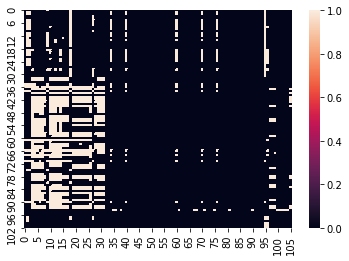

In [27]:
sns.heatmap(adj_mat)

In [194]:
from sklearn.cluster import SpectralClustering

In [163]:
sc = SpectralClustering(2, affinity='precomputed', n_init=100, assign_labels='discretize')

In [ ]:
sc.fi

In [28]:
num_classes, num_nodes = 6, G.number_of_nodes()
print(num_classes, num_nodes)
theta = np.full((num_classes,num_classes), 1. / num_classes)
alpha = np.full(num_classes, 1. / num_classes)
tau = np.full((num_nodes, num_classes), 1. / num_classes)

6 106


In [38]:
print(np.log(theta[:,0]))

[-1.79175947 -1.79175947 -1.79175947 -1.79175947 -1.79175947 -1.79175947]


In [193]:
# E step
from tqdm import tqdm_notebook as tqdm
import time
L_old = 0
L_vec = []
for step in range(10):
    start = time.time()
    # print('step ',step)
    tau_new_log = np.zeros((num_nodes, num_classes))
    for i in range(num_nodes):
        for q in range(num_classes):
            tau_new_log[i,q] = 0
            for j in range(num_nodes): 
                if(i != j):
                    b_mat = (
                        adj_mat[i,j] * np.log(theta[q,]) +
                        (1 - adj_mat[i,j]) * (np.log(1 - theta[q,])) +
                        adj_mat[j,i] * np.log(theta[:,q]) +
                        (1 - adj_mat[i,j]) * (np.log(1 - theta[:,q]))
                    )
                    #print(b_mat.shape, tau[j,].shape)

                    tau_new_log[i,q] += np.dot(tau[j,],b_mat)
            tau_new_log[i,q] += np.log(alpha[q])
    tau_new = np.exp(tau_new_log)
    tau = tau_new.copy()
    tau = tau / tau.sum(axis=1, keepdims=1)

    # M step
    # Calculate alpha
    alpha = tau.sum(axis = 0) / num_nodes
    alpha = alpha / alpha.sum()
    # Calculate theta
    for q in range(num_classes):
        for r in range(num_classes):
            num = 0
            denom = 0
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if ( i != j):
                        num += adj_mat[i,j] * tau[i,q] * tau[j,r]
                        denom +=  tau[i,q] * tau[j,r]
            theta[q,r] = num / denom
        theta[q,] = theta[q,] / theta[q,].sum()

    L = np.dot(tau.sum(axis = 0), np.log(alpha)) 
    for i in range(num_nodes):
        for j in range(num_nodes):
            if( i != j ):
                for q in range(num_classes):
                    for r in range(num_classes):
                        L += (0.5) * (
                            tau[i,q] * tau[j,r] *
                            (adj_mat[i,j] * np.log(theta[q,r]) +
                            (1 - adj_mat[i,j]) * np.log(1 - theta[q,r]))
                        )

    end = time.time()
    L_vec += [L]
    print('diff...{} elapsed time...{}'.format(L - L_old, end - start))
    L_old = L

diff...-2298.9637477407 elapsed time...6.5016138553619385
diff...0.0 elapsed time...6.8583457469940186
diff...0.0 elapsed time...6.8287365436553955


KeyboardInterrupt: 

In [190]:
tau

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0

In [182]:
tau

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, na